<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COVID-19 Workaround 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)

In [166]:
df.head() # show firt lines of downloded data

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695


In [217]:
np.array(df['data'])[6]

'2020-03-01 18:00:00'

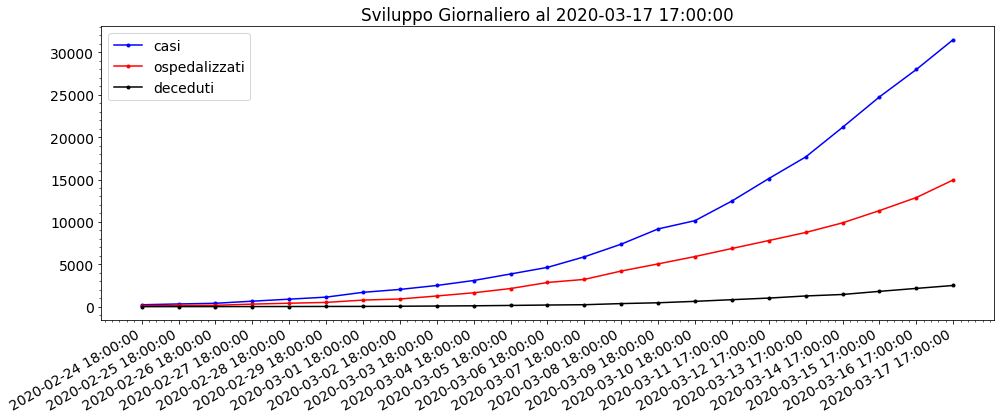

In [168]:
# visualize Daly data of infected and death people
plt.style.use('fast')
plt.rc('font', size = 14, family ='Sans-Serif')
fig, ax = plt.subplots(figsize=(16,6))
fig.autofmt_xdate()
ax.plot(df['data'], df['totale_casi'], 'b.-', label='casi')
ax.plot(df['data'], df['totale_ospedalizzati'], 'r.-', label='ospedalizzati')
ax.plot(df['data'], df['deceduti'], 'k.-', label='deceduti')
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Sviluppo Giornaliero al '+str(np.array(df['data'])[-1]))
#ax.set_yscale('log')
ax.legend(loc=2)
plt.minorticks_on()
plt.show()

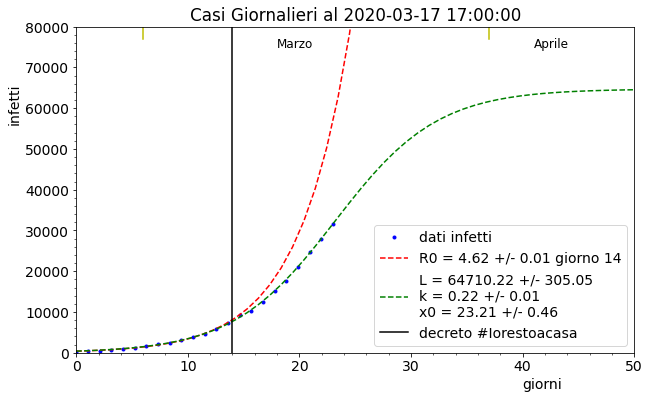

In [237]:
def Exp(x, p0, p1): # negative exponential

    import numpy as np
    return p0*np.exp(x/p1)

def Logistic(x, L, k, x0):
    return L / (1. + np.exp(-k * (x - x0)))

from scipy.optimize import curve_fit
x = np.linspace(0, len(df['data']), len(df['data']))

max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['totale_casi'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, df['totale_casi'], 'b.', label='dati infetti')
popt_l,pcov_l = curve_fit(Logistic,x, df['totale_casi'], p0=[4000.,4., 10.])
perr_l = np.sqrt(np.diag(pcov))
x=np.linspace(0,50,50)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f} giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Logistic(x, *popt_l), 'g--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2]))
ax.set_xlim(0,50)
ax.set_ylim(0,80000)
ax.plot([14,14], [0,80000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [77000,80000], 'y-')
ax.plot([6+31,6+31], [77000,80000], 'y-')
ax.text(6+35, 75000, 'Aprile', fontsize=12)
ax.text(6+12, 75000, 'Marzo', fontsize=12)
ax.set_title('Casi Giornalieri al '+str(np.array(df['data'])[-1]))
ax.legend(loc=4)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('infetti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()


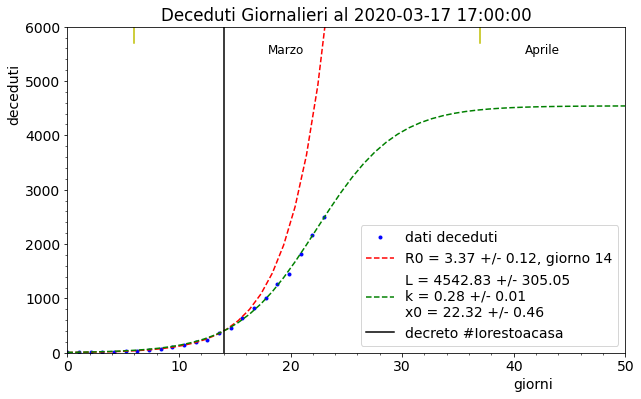

In [238]:
x = np.linspace(0, len(df['data']), len(df['data']))

max_exp_fit = 14
popt_e,pcov_e = curve_fit(Exp,x[x<max_exp_fit], df['deceduti'][x<max_exp_fit], p0=[1,2])
perr_e = np.sqrt(np.diag(pcov_e))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, df['deceduti'], 'b.', label='dati deceduti')
popt_l,pcov_l = curve_fit(Logistic,x, df['deceduti'], p0=[4000.,4., 10.])
perr_l = np.sqrt(np.diag(pcov_l))
x=np.linspace(0,50,50)
ax.plot(x, Exp(x, *popt_e), 'r--', label='R0 = {0:.2f} +/- {1:.2f}, giorno {2:d}'.format(popt_e[1], perr_e[1], max_exp_fit))
ax.plot(x, Logistic(x, *popt_l), 'g--', label='L = {0:.2f} +/- {1:.2f}\nk = {2:.2f} +/- {3:.2f} \
\nx0 = {4:.2f} +/- {5:.2f}'.format(popt_l[0], perr_l[0], popt_l[1], perr_l[1], popt_l[2], perr_l[2]))
#ax.set_yscale('log')
ax.set_xlim(0,50)
ax.set_ylim(0,6000)
ax.plot([14,14], [0,6000], 'k-', label='decreto #Iorestoacasa')
ax.plot([6,6], [5700,6000], 'y-')
ax.plot([6+31,6+31], [5700,6000], 'y-')
ax.text(6+35, 5500, 'Aprile', fontsize=12)
ax.text(6+12, 5500, 'Marzo', fontsize=12)
ax.legend(loc=4)
ax.set_title('Deceduti Giornalieri al '+str(np.array(df['data'])[-1]))
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel('deceduti', horizontalalignment = 'left', y=0.7)
plt.minorticks_on()
plt.show()
